In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

2023-09-13 11:45:57.095454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 11:45:57.760046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13587841774089956297
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2764439552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 655585371899455227
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-09-13 11:45:59.055854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 11:45:59.081161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 11:45:59.081477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
num_samples = 10000
num_dimensions = 30

# Generate random samples
raw_data = np.random.rand(num_samples, num_dimensions)

outlier_indices_1 = [0,1,2,3,4,5,6]
outlyin_amount_1 = 20
outlier_indices_2 = [0,2,4,6,8,10,12]
outlyin_amount_2 = 10
outlier_indices_3 = [0,3,6,9,12,15,18]
outlyin_amount_3 = 5
outlier_indices_4 = [0,4,8,12,16,20,24]
outlyin_amount_4 = 2
outlier_indices_5 = [0,5,10,15,20,25,29]
outlyin_amount_5 = 1.1
outlier_indices_6 = [0,1,2,3,4,5,6]
outlyin_amount_6 = [20,15,10,5,2,1.1,1.05]

corrupted_data = raw_data

corrupted_data[100:120, outlier_indices_1] = outlyin_amount_1
corrupted_data[200:220, outlier_indices_2] = outlyin_amount_2
corrupted_data[300:320, outlier_indices_3] = outlyin_amount_3
corrupted_data[400:420, outlier_indices_4] = outlyin_amount_4
corrupted_data[500:520, outlier_indices_5] = outlyin_amount_5
corrupted_data[600:620, outlier_indices_6] = outlyin_amount_6

for outlier_gene_index in range(corrupted_data.shape[1]+1):
    corrupted_data[700+outlier_gene_index,:outlier_gene_index] = outlyin_amount_1
    
normalized_arr = (corrupted_data - np.min(corrupted_data,axis = 0)) / (np.max(corrupted_data,axis = 0) - np.min(corrupted_data,axis = 0))

# print(raw_data)

# Training VAE

In [3]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 2

encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(30, activation="tanh")(encoder_inputs)
x = layers.Dense(20, activation="tanh")(x)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(16, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(16, activation="tanh")(latent_inputs)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(20, activation="tanh")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.15 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

creditdata = np.concatenate([normalized_arr], axis=0)
creditdata = np.expand_dims(creditdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
history = vae.fit(creditdata, epochs=100, batch_size=256)

2023-09-07 15:44:33.144088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-07 15:44:33.144219: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
40/40 [==============================] - 1s 1ms/step - loss: 0.0326 - reconstruction_loss: 0.0194 - kl_loss: 0.0068
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0044 - reconstruction_loss: 0.0039 - kl_loss: 2.8660e-04
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0030 - reconstruction_loss: 0.0029 - kl_loss: 1.2721e-04
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0031 - reconstruction_loss: 0.0030 - kl_loss: 7.7876e-05
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0025 - reconstruction_loss: 0.0026 - kl_loss: 5.2627e-05
Epoch 6/100
40/40 [==============================] - 0s 984us/step - loss: 0.0023 - reconstruction_loss: 0.0025 - kl_loss: 3.8424e-05  
Epoch 7/100
40/40 [==============================] - 0s 992us/step - loss: 0.0024 - reconstruction_loss: 0.0025 - kl_loss: 3.0054e-05  
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss:

# Training RAE

In [3]:
latent_dim = 2
# num_dimensions = 3

# normalizing 

normalized_arr = (corrupted_data - np.min(corrupted_data,axis = 0)) / (np.max(corrupted_data,axis = 0) - np.min(corrupted_data,axis = 0))


encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(20, activation="sigmoid")(encoder_inputs)
x = layers.Dense(18, activation="sigmoid")(x)
x = layers.Dense(16, activation="sigmoid")(x)
encoder_output = layers.Dense(latent_dim, activation="sigmoid")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(16, activation="sigmoid")(latent_inputs)
x = layers.Dense(18, activation="sigmoid")(x)
x = layers.Dense(20, activation="sigmoid")(x)
# x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class RAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.z_tracker = keras.metrics.Mean(name="z_loss")
        self.REG_tracker = keras.metrics.Mean(name="REG_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.z_tracker,
            self.REG_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(data,reconstruction)
            # reconstruction_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(data, reconstruction)
#             
            z_loss = K.mean(K.square(z), axis=[1])
    

#             gradients = tape.gradient(reconstruction, self.encoder(data))
    

#             gradient_norm = 0.0
#             for gradient in gradients:
#                 if gradient is not None:
#                     gradient_norm += tf.norm(gradient, ord=2)
    

            REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))

            z_loss_w = 0.01
            REG_loss_w = 0.01

            total_loss = reconstruction_loss +  z_loss_w * z_loss + REG_loss_w * REG_loss
            # total_loss = reconstruction_loss
        
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.z_tracker.update_state(z_loss)
            self.REG_tracker.update_state(REG_loss)
            del tape
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "z_loss": self.z_tracker.result(),
                "REG_loss": self.REG_tracker.result(),
            }
        

# mnist_data = mat_data['X']
tdata = np.concatenate([normalized_arr], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

rae = RAE(encoder, decoder)
rae.compile(optimizer=tf.keras.optimizers.Adam())
history = rae.fit(tdata, epochs=100, batch_size=128)

2023-09-13 11:46:06.059713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 11:46:06.059973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 11:46:06.060104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-09-13 11:46:07.664017: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f46c46a24e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-13 11:46:07.664072: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-09-13 11:46:07.667939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 11:46:07.820223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-13 11:46:07.942259: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 3s 4ms/step - loss: 0.2159 - reconstruction_loss: 0.1678 - z_loss: 0.3772 - REG_loss: 3.2939e-06
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0652 - reconstruction_loss: 0.0465 - z_loss: 0.1365 - REG_loss: 1.0323e-05
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0170 - reconstruction_loss: 0.0132 - z_loss: 0.0555 - REG_loss: 5.6844e-06
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0079 - reconstruction_loss: 0.0065 - z_loss: 0.0282 - REG_loss: 2.1785e-06
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0047 - reconstruction_loss: 0.0044 - z_loss: 0.0168 - REG_loss: 9.9037e-07
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0036 - reconstruction_loss: 0.0035 - z_loss: 0.0113 - REG_loss: 5.3070e-07
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0031 - reconstruction_loss: 0.0031 - 

In [4]:
inliers = normalized_arr[5:80,:]
mean_data = np.mean(normalized_arr, axis=0)
outlier1 = normalized_arr[101,:]

In [8]:




# #------------------ replacing the genes here ---------------------

# inliers[:,1] = mean_data[1]

# outlier1[1] = mean_data[1]

# # ----------------------------------------------------------------

mean_mean = []

for step in range(10):

    mean_data = outlier1.reshape([1,30])

    z_mean, z_log_var, z = vae.encoder(mean_data)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(mean_data,reconstruction)

    print(reconstruction_loss.numpy())
    
    mean_mean.append(reconstruction_loss.numpy())

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

0.21770996
0.2182426
0.2197542
0.2175522
0.21677516
0.21931668
0.22014053
0.21823397
0.21645944
0.2208292
MEAN_MEAN =  0.21850137
std_MEAN =  0.0013840148


In [9]:
mean_mean = []

for step in range(10):

    mean_ins_error = []

    for index in range(inliers.shape[0]):

        cand = inliers[index,:]

        cand = cand.reshape([1,30])

        mean_data = mean_data.reshape([1,30])

        z_mean, z_log_var, z = vae.encoder(cand)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

        mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

    mean_ins_error = np.array(mean_ins_error)
    print("mean = ", np.mean(mean_ins_error))
    
    mean_mean.append(np.mean(mean_ins_error))
    

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

mean =  0.00025608146
mean =  0.00024746358
mean =  0.0002541486
mean =  0.00025939767
mean =  0.0002530513
mean =  0.00024830017
mean =  0.0002470074
mean =  0.00024741032
mean =  0.00024775096
mean =  0.0002449741
MEAN_MEAN =  0.00025055854
std_MEAN =  4.516684e-06


In [8]:
mean_data = outlier1.reshape([1,30])

z = rae.encoder(mean_data)
reconstruction = rae.decoder(z)

reconstruction_loss = tf.keras.losses.MeanSquaredError()(mean_data,reconstruction)

print(reconstruction_loss.numpy())

0.2190216


In [10]:
mean_mean = []

mean_ins_error = []

for index in range(inliers.shape[0]):

    cand = inliers[index,:]

    cand = cand.reshape([1,30])

    mean_data = mean_data.reshape([1,30])

    z = rae.encoder(cand)
    reconstruction = rae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

    mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

mean_ins_error = np.array(mean_ins_error)
print("mean = ", np.mean(mean_ins_error))


mean =  0.00023025127


In [38]:
def fit_test(solution): 
       
    inliers = corrupted_data[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = corrupted_data[101,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        
        
        in_remain = candidate_inlier * in_normal_subspace
        

        
        in_replace = in_bad_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_normal_subspace = solution
    out_bad_subspace = 1 - solution
    
    out_remain = particle * out_normal_subspace
    

    
    out_replace = avg_ins * out_bad_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return -fitness



def fitness_func_avg(ga_instance, solution, solution_idx):
    
    fit_mean = []

    for i in range(10):
        fit_mean.append(fit_test(solution))

    return np.mean(np.array(fit_mean))

def on_generation(ga):
    print("Generation", ga.generations_completed)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
#     wandb.log({"solution_fitness": solution_fitness})
    
    print(solution_fitness)


    
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="my-project-dual-test",
    
#     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": 0.02,
# #     "architecture": "CNN",
# #     "dataset": "CIFAR-100",
# #     "epochs": 20,
# #     }
# )

fitness_function = fitness_func_avg

num_generations = 40
num_parents_mating = 2

sol_per_pop = 10
num_genes = corrupted_data.shape[1]

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10
keep_elitism = 5

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
#                        keep_parents=keep_parents,
                       keep_elitism = keep_elitism,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       gene_space = space)

In [39]:
ga_instance.run()
# wandb.finish()

Generation 1
-409.7479
Generation 2
-406.71332
Generation 3
-398.761
Generation 4
-376.8354
Generation 5
-212.04866
Generation 6
-207.36613
Generation 7
-196.63754
Generation 8
-193.98148
Generation 9
-196.03761
Generation 10
-196.03761
Generation 11
-196.03761
Generation 12
-196.03761
Generation 13
-196.03761
Generation 14
-196.03761
Generation 15
-192.92493
Generation 16
-0.6934384
Generation 17
-0.70246756
Generation 18
-0.5470918
Generation 19
-0.51984453
Generation 20
-0.51874584
Generation 21
-0.38416567
Generation 22
-0.41924635
Generation 23
-0.41924635
Generation 24
-0.41924635
Generation 25
-0.41924635
Generation 26
-0.41924635
Generation 27
-0.41924635
Generation 28
-0.41924635
Generation 29
-0.41924635
Generation 30
-0.41924635
Generation 31
-0.41924635
Generation 32
-0.41924635
Generation 33
-0.41924635
Generation 34
-0.41924635
Generation 35
-0.41924635
Generation 36
-0.41924635
Generation 37
-0.41924635
Generation 38
-0.41924635
Generation 39
-0.41924635
Generation 40
-0

In [40]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1.]
Fitness value of the best solution = -0.4192463457584381


In [35]:
# candid_sol = np.ones([1,30])
# candid_sol[0,outlier_indices_1] = 0
# # print(fit_test(solution))

# sol_mean = []
# candid_sol_mean = []

# for i in range(100):
#     sol_mean.append(fit_test(solution))
# print(np.mean(np.array(sol_mean)))

# for i in range(100):
#     candid_sol_mean.append(fit_test(candid_sol))
# print(np.mean(np.array(candid_sol_mean)))

-0.6686041
-0.7054567


# For Loop for Genetic Algorithm

In [9]:
best_solutions = []

wandb.init(
    # set the wandb project where this run will be logged
    project="RAE_Outlier_GA_Dual_Test_normalized",
    
    # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 20,
#     }
)

for out_indexing in range(1,normalized_arr.shape[1]+1):
    
    def fitness_func(ga_instance, solution, solution_idx):

        inliers = normalized_arr[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = normalized_arr[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []
        avg_in_z = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_normal_subspace = solution
            in_bad_subspace = 1 - solution        

            in_remain = candidate_inlier * in_normal_subspace



            in_replace = in_bad_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z = rae.encoder(in_candidate)
            in_candidate_rec = rae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
            # z_loss = K.square(K.gradients(K.square(in_candidate_rec), z))
            z_loss = K.mean(K.square(z), axis=[1])

            avg_in_rec.append(rec_loss.numpy())
            avg_in_z.append(z_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)
        avg_in_z = np.array(avg_in_z)
        avg_in_z = np.mean(avg_in_z)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_normal_subspace = solution
        out_bad_subspace = 1 - solution

        out_remain = particle * out_normal_subspace



        out_replace = avg_ins * out_bad_subspace

        out_candidate = out_remain + out_replace


        z = rae.encoder(out_candidate)
        out_candidate_rec = rae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = rec_loss / (avg_in_rec + 10*avg_in_z)

        return -fitness



    # def fitness_func_avg(ga_instance, solution, solution_idx):

    #     fit_mean = []

    #     for i in range(10):
    #         fit_mean.append(fit_test(solution))

    #     return np.mean(np.array(fit_mean))

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        
        wandb.log({"GA - " + str(out_indexing) + "/solution_fitness": solution_fitness})

        print(solution_fitness)


    fitness_function = fitness_func

    num_generations = 40
    num_parents_mating = 2

    sol_per_pop = 20
    num_genes = normalized_arr.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "tournament"
    K_tournament = 5
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 5

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           K_tournament = K_tournament,
                           # keep_parents=keep_parents,
                           keep_elitism=5,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("##########  End of the ", out_indexing, " epoch ##########")
    print("Parameters of the best solution : {solution}".format(solution=solution))

    best_solutions.append(solution)
    
    sample = corrupted_data[700+out_indexing,:]
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for gene_no in range(30):
        
        if ((sample[gene_no] == 20) and (solution[gene_no] == 0)):
            
            TP = TP + 1
        
        elif (sample[gene_no] != 20) and (solution[gene_no] == 0):
            
            FP = FP + 1
            
        elif (sample[gene_no] != 20) and (solution[gene_no] == 1):
            
            TN = TN + 1
            
        elif (sample[gene_no] == 20) and (solution[gene_no] == 1):
            
            FN = FN + 1
    
    try:
        precision = TP / (TP + FP)
    except:
        print("********************************** CHECK! **********************************************")
        precision = 1

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    wandb.log({"Metrics/precision": precision, 
               "Metrics/recall": recall,
               "Metrics/F1": F1,
               "Metrics/MCC": MCC,
               "Metrics/num": out_indexing})
    
best_solutions = np.array(best_solutions)
np.save('best_solutions.npy', best_solutions)

GA - 1/solution_fitness,▁▃▃▄▆▆▆▆▇▇██████████████████████████████
GA - 2/solution_fitness,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇████████████████████████
GA - 3/solution_fitness,▁▃▃▄▅▅▅▅▆▇▇▇▇▇▇▇███████████████
Metrics/F1,▁█
Metrics/MCC,▁█
Metrics/num,▁█
Metrics/precision,▁█
Metrics/recall,▁▁
GA - 1/solution_fitness,-0.42422
GA - 2/solution_fitness,-0.47149
GA - 3/solution_fitness,-0.38924


Generation 1
-0.4461492442828721
Generation 2
-0.421055611936453
Generation 3
-0.40698974286059036
Generation 4
-0.3968189950070518
Generation 5
-0.3707298890162277
Generation 6
-0.3513853640160585
Generation 7
-0.34847646679715977
Generation 8
-0.32914850723692063
Generation 9
-0.29529094295500835
Generation 10
-0.28269503493018733
Generation 11
-0.28269503493018733
Generation 12
-0.27733321144540574
Generation 13
-0.26652862192655785
Generation 14
-0.26652862192655785
Generation 15
-0.2662916232024302
Generation 16
-0.2662916232024302
Generation 17
-0.2556460210649256
Generation 18
-0.2556460210649256
Generation 19
-0.2556460210649256
Generation 20
-0.2556460210649256
Generation 21
-0.25559850995752476
Generation 22
-0.25559850995752476
Generation 23
-0.25512630611531967
Generation 24
-0.2543929459493863
Generation 25
-0.2543929459493863
Generation 26
-0.2543929459493863
Generation 27
-0.2543929459493863
Generation 28
-0.2543929459493863
Generation 29
-0.2543929459493863
Generation 3

KeyboardInterrupt: 

In [11]:
def fit_test_vae(solution): 
       
    inliers = normalized_arr[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = normalized_arr[101,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        
        
        in_remain = candidate_inlier * in_normal_subspace
        

        
        in_replace = in_bad_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_normal_subspace = solution
    out_bad_subspace = 1 - solution
    
    out_remain = particle * out_normal_subspace
    

    
    out_replace = avg_ins * out_bad_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return -fitness



def fit_test_rae(solution): 
       
    inliers = normalized_arr[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = normalized_arr[101,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        
        
        in_remain = candidate_inlier * in_normal_subspace
        

        
        in_replace = in_bad_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z = rae.encoder(in_candidate)
        in_candidate_rec = rae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_normal_subspace = solution
    out_bad_subspace = 1 - solution
    
    out_remain = particle * out_normal_subspace
    

    
    out_replace = avg_ins * out_bad_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z = rae.encoder(out_candidate)
    out_candidate_rec = rae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return -fitness

# RAE Testing

In [12]:
sol = np.ones([1,30])
# sol_fitness = []

print(np.abs(fit_test_rae(sol)))

1046.3853


In [14]:
sol = np.ones([1,30])
sol[0,0] = 0

print(np.abs(fit_test_rae(sol)))

941.04865


In [15]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0

print(np.abs(fit_test_rae(sol)))

785.47424


In [ ]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0

print(np.abs(fit_test_rae(sol)))

In [30]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0

total_rec = []

particle = normalized_arr[101,:]
particle = particle.reshape([1,30])


inliers = normalized_arr[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,30])


out_normal_subspace = sol
out_bad_subspace = 1 - sol

out_remain = particle * out_normal_subspace



out_replace = avg_ins * out_bad_subspace

out_candidate = out_remain + out_replace


for I in range(100):
    z = rae.encoder(out_candidate)
    out_candidate_rec = rae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    total_rec.append(rec_loss)

# print(rec_loss)
total_rec_rae_3 = np.array(total_rec)


In [15]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0


in_total_rec = []

particle = normalized_arr[101,:]
particle = particle.reshape([1,30])


inliers = normalized_arr[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,30])


for i in range(100):
    
    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
    
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
    
        in_normal_subspace = sol
        in_bad_subspace = 1 - sol        
    
        in_remain = candidate_inlier * in_normal_subspace
    
    
    
        in_replace = in_bad_subspace * avg_ins
    
        in_candidate = in_remain + in_replace
    
        z = rae.encoder(in_candidate)
        in_candidate_rec = rae.decoder(z)
    
    
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        z_loss = K.mean(K.square(z), axis=[1])
        avg_in_rec.append(z_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
    

    in_total_rec.append(avg_in_rec)


in_total_rec_3 = np.array(in_total_rec)
    
    

In [42]:
in_total_rec_3

array([0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019937,
       0.00019937, 0.00019937, 0.00019937, 0.00019937, 0.00019

# VAE Testing

In [11]:
sol = np.ones([1,30])
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_0 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

974.31464
81.38415


In [12]:
sol = np.ones([1,30])
sol[0,0] = 0
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_1 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

871.2659
79.86199


In [13]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_2 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

726.1029
64.22896


In [14]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_3 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

591.8579
51.851982


In [20]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0

total_rec = []

particle = normalized_arr[101,:]
particle = particle.reshape([1,30])


inliers = normalized_arr[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,30])


out_normal_subspace = sol
out_bad_subspace = 1 - sol

out_remain = particle * out_normal_subspace



out_replace = avg_ins * out_bad_subspace

out_candidate = out_remain + out_replace

for i in range(1000):
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    total_rec.append(rec_loss)

total_rec_3 = np.array(total_rec)

# print(np.mean(total_rec))
# print(np.std(total_rec))

    


In [35]:
sol = np.ones([1,30])
# sol[0,0] = 0
# sol[0,1] = 0
# sol[0,2] = 0


in_total_rec = []

particle = normalized_arr[101,:]
particle = particle.reshape([1,30])


inliers = normalized_arr[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,30])

for i in range(1000):
    
    avg_in_rec = []
    
    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])

        in_normal_subspace = sol
        in_bad_subspace = 1 - sol        

        in_remain = candidate_inlier * in_normal_subspace



        in_replace = in_bad_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

        avg_in_rec.append(rec_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
    
    in_total_rec.append(avg_in_rec)
    

in_total_rec_0 = np.array(in_total_rec)
    
    

In [21]:
in_total_rec_3

array([1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.168803e-05,
       1.168803e-05, 1.168803e-05, 1.168803e-05, 1.1688

In [18]:
z_mean, z_log_var, z = vae.encoder(particle)
reconstructed = vae.decoder(z)

rec_loss = tf.keras.losses.MeanSquaredError()(reconstructed,particle)
rec_loss = rec_loss.numpy()
print(particle)
print(reconstructed)
print(rec_loss)

[[1.         1.         1.         1.         1.         1.
  1.         0.00297515 0.01510315 0.03385247 0.02889087 0.01653609
  0.0416705  0.01380664 0.01302149 0.02799379 0.0239093  0.02229641
  0.00778653 0.0252289  0.01294949 0.01959757 0.03666489 0.04683846
  0.03869174 0.02028072 0.02964397 0.03732108 0.02070391 0.01801135]]
tf.Tensor(
[[0.0348127  0.02434092 0.03297227 0.0296979  0.02301956 0.02120499
  0.01868577 0.02015038 0.03088838 0.03234825 0.03234005 0.03642559
  0.02926851 0.02185646 0.02128324 0.03174393 0.0235996  0.03306892
  0.02981786 0.02041823 0.01804982 0.02450623 0.02639421 0.02664656
  0.03106015 0.01795425 0.0231435  0.02068016 0.01900377 0.0202697 ]], shape=(1, 30), dtype=float32)
0.2212822565309322


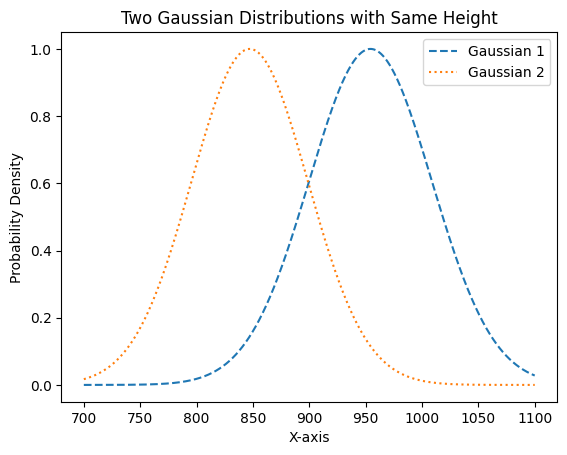

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the Gaussian distributions
mu1, sigma1 = 954.3, 54.47  # Mean and standard deviation for the first Gaussian
mu2, sigma2 = 847.13, 51.57  # Mean and standard deviation for the second Gaussian
height = 1.0  # Height of both Gaussian distributions

# Generate data points for the x-axis
x = np.linspace(700, 1100, 10000)

# Calculate the probability density functions (PDFs) for the two Gaussians
pdf1 = norm.pdf(x, mu1, sigma1)
pdf2 = norm.pdf(x, mu2, sigma2)

# Scale the PDFs to have the same height
pdf1 *= height / pdf1.max()
pdf2 *= height / pdf2.max()

# Plot the two Gaussian distributions
plt.plot(x, pdf1, label='Gaussian 1', linestyle='dashed')
plt.plot(x, pdf2, label='Gaussian 2', linestyle='dotted')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Two Gaussian Distributions with Same Height')

# Add legend
plt.legend()

# Show the plot
plt.show()


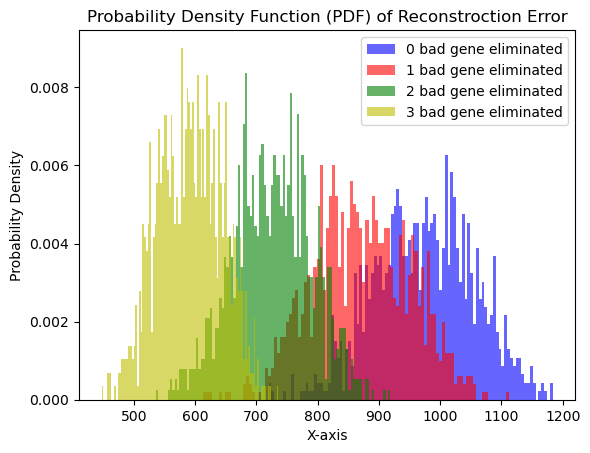

In [16]:
plt.hist(sol_fitness_0, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(sol_fitness_1, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(sol_fitness_2, bins=100, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(sol_fitness_3, bins=100, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Fitness Function')

# Show the plot
plt.legend()
plt.show()

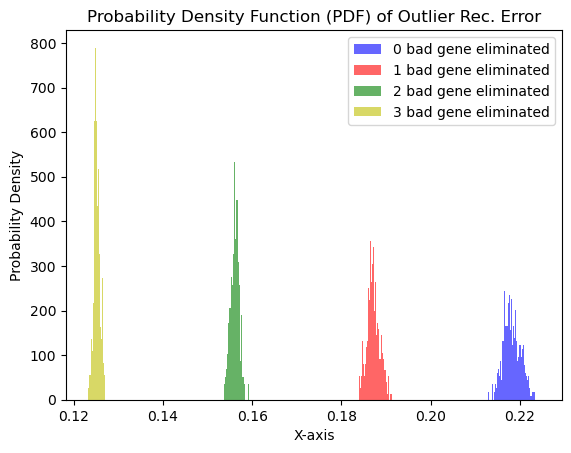

In [21]:
plt.hist(total_rec_0, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(total_rec_1, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(total_rec_2, bins=100, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(total_rec_3, bins=100, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Outlier Rec. Error')

# Show the plot
plt.legend()
plt.show()

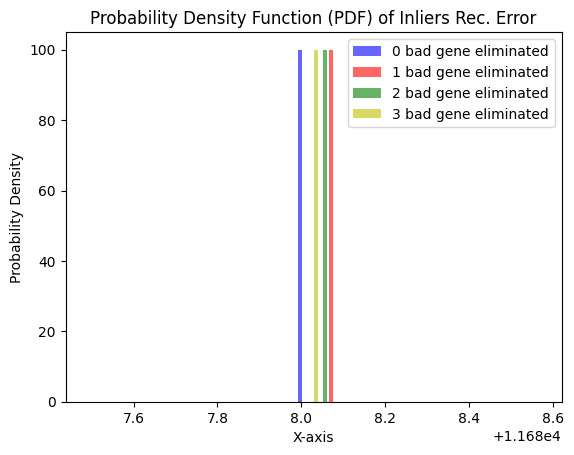

In [23]:
plt.hist(in_total_rec_0*1000000000, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(in_total_rec_1*1000000000, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(in_total_rec_2*1000000000, bins=100, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(in_total_rec_3*1000000000, bins=100, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Inliers Rec. Error')

# Show the plot
plt.legend()
plt.show()

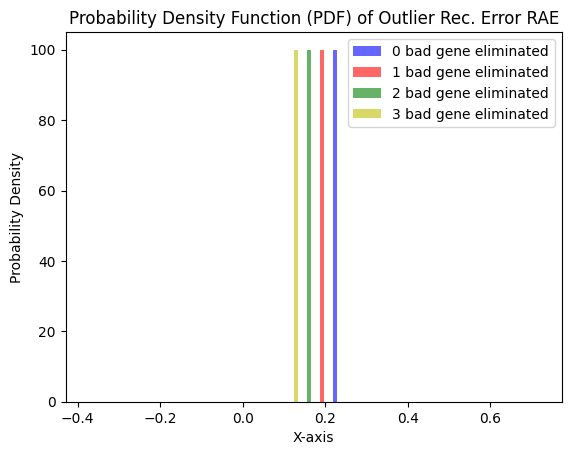

In [37]:
plt.hist(total_rec_rae_0, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(total_rec_rae_1, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(total_rec_rae_2, bins=100, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(total_rec_rae_3, bins=100, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Outlier Rec. Error RAE')

# Show the plot
plt.legend()
plt.show()

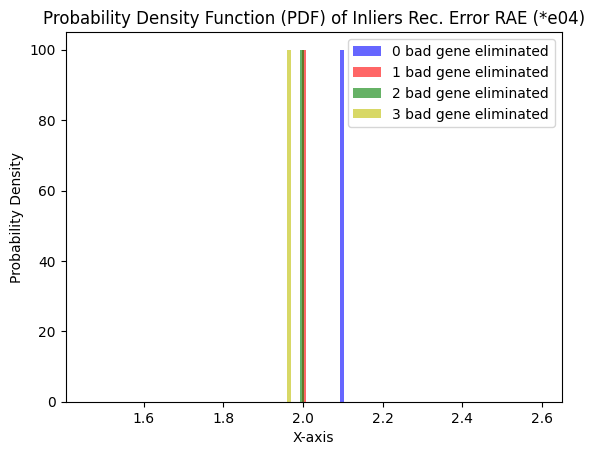

In [61]:
plt.hist(in_total_rec_0 * 10000, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(in_total_rec_1 * 10000, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(in_total_rec_2 * 10000, bins=100, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(in_total_rec_3 * 10000, bins=100, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Inliers Rec. Error RAE (*e04)')

# Show the plot
plt.legend()
plt.show()

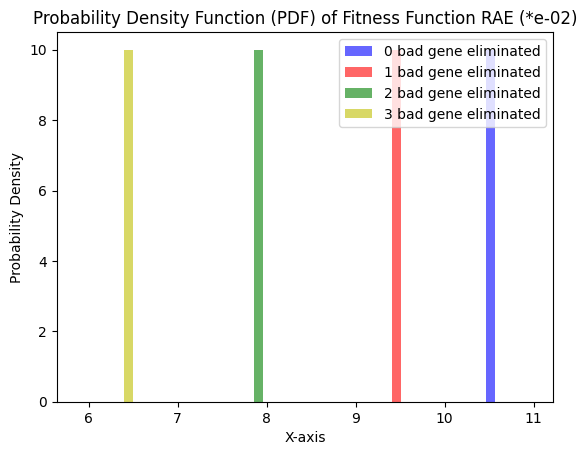

In [65]:
a0 = total_rec_rae_0/in_total_rec_0
a1 = total_rec_rae_1/in_total_rec_1
a2 = total_rec_rae_2/in_total_rec_2
a3 = total_rec_rae_3/in_total_rec_3



plt.hist(a0/100, bins=10, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(a1/100, bins=10, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
plt.hist(a2/100, bins=10, density=True, alpha=0.6, color='g', label='2 bad gene eliminated')
plt.hist(a3/100, bins=10, density=True, alpha=0.6, color='y', label='3 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Fitness Function RAE (*e-02)')

# Show the plot
plt.legend()
plt.show()

In [63]:
total_rec_rae_0

array([0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216, 0.2190216,
       0.2190216, 0.2190216, 0.2190216, 0.2190216, 